### 초기 경로 설정 (클래스 이용을 위함)

In [5]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [6]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [7]:
from models.DeepLab_V3_p.model import DeepLab as DeepLab_V3_p

random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [9]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [10]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [11]:
train_images = glob.glob('/data/segmentation/Kvasir-SEG/trainset/images/*')
train_labels = glob.glob('/data/segmentation/Kvasir-SEG/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/Kvasir-SEG/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/Kvasir-SEG/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외


train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)


custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))


custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

# train_images = sorted(train_images)
# train_labels = sorted(train_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)
        
# valid_images = sorted(valid_images)
# valid_labels = sorted(valid_labels)
# for x,y in zip(train_images, train_labels):
#     x = x.split('/')[-1].split('.jpg')[0]
#     y = y.split('/')[-1].split('_seg')[0]
#     if x != y:
#         print('다릅니다', x, y)

My custom training-dataset has 800 elements
My custom valing-dataset has 200 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

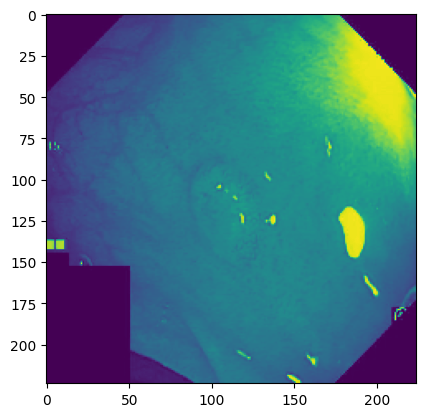

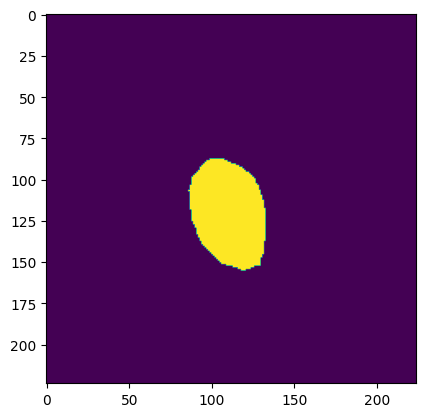

3픽셀의 평균값이라 색깔이 변경됨.


In [12]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [13]:
# Begin training
model = DeepLab_V3_p(backbone = 'xception', num_classes = 1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [14]:
# Define variables for the training
epochs = 50
patience = 10
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [15]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

# criterion = IoULoss()
# model_name = 'UNet_IoULoss_baseline'

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCELoss_baseline'

criterion = DiceBCELoss()
model_name = 'DeepLab_v3_p_DiceBCELoss_baseline'


# 5. Training

In [16]:
def dice_pytorch_eval(outputs: torch.Tensor, labels: torch.Tensor):

    # comment out if your model contains a sigmoid or equivalent activation layer
    outputs = torch.sigmoid(outputs)

    # thresholding since that's how we will make predictions on new imputs
    outputs = outputs > 0.5

    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # (BATCH, 1, H, W) -> (BATCH, H, W)
    labels = labels.squeeze(1).byte()


    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    dice = 2 * (intersection + SMOOTH) / (intersection + union + SMOOTH) # We smooth our devision to avoid 0/0

    return dice.mean()

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 0 of 50, Iter.: 100 of 100, Train Loss: 1.120179, IoU: 0.327465, Dice: 0.454006
 Epoch: 0 of 50, Iter.: 100 of 100, Valid Loss: 1.051250, IoU: 0.344889, Dice: 0.472361

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


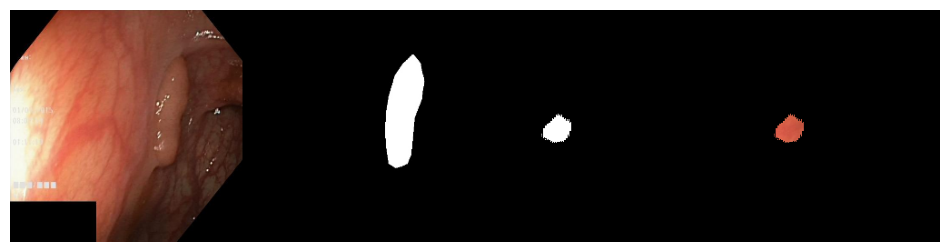

 Epoch: 1 of 50, Iter.: 100 of 100, Train Loss: 0.949372, IoU: 0.402566, Dice: 0.533986
 Epoch: 1 of 50, Iter.: 100 of 100, Valid Loss: 0.843317, IoU: 0.446363, Dice: 0.563114


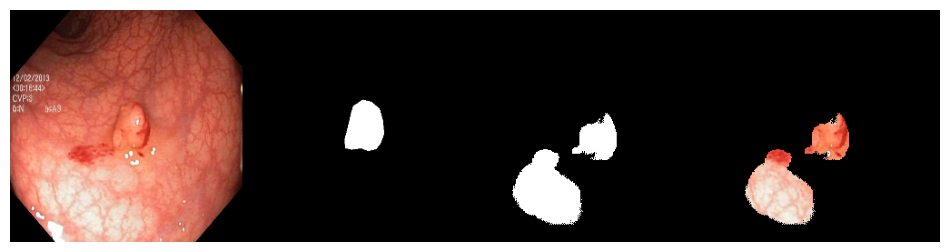

 Epoch: 2 of 50, Iter.: 100 of 100, Train Loss: 0.852315, IoU: 0.440755, Dice: 0.568354
 Epoch: 2 of 50, Iter.: 100 of 100, Valid Loss: 0.991405, IoU: 0.408262, Dice: 0.543727


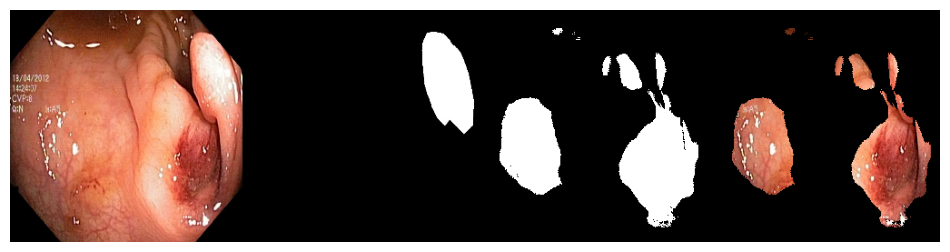

 Epoch: 3 of 50, Iter.: 100 of 100, Train Loss: 0.765102, IoU: 0.474466, Dice: 0.597140
 Epoch: 3 of 50, Iter.: 100 of 100, Valid Loss: 0.769469, IoU: 0.478871, Dice: 0.595740


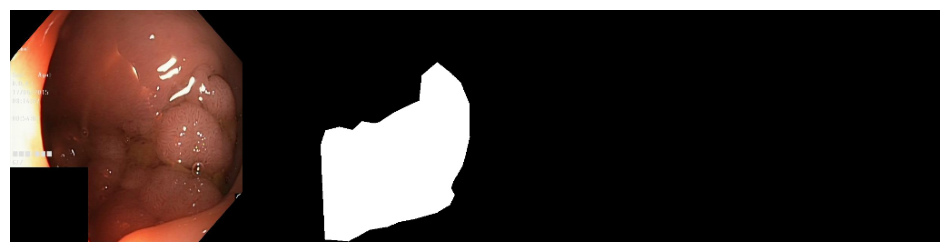

 Epoch: 4 of 50, Iter.: 100 of 100, Train Loss: 0.710759, IoU: 0.495634, Dice: 0.614363
 Epoch: 4 of 50, Iter.: 100 of 100, Valid Loss: 0.758130, IoU: 0.462382, Dice: 0.568384


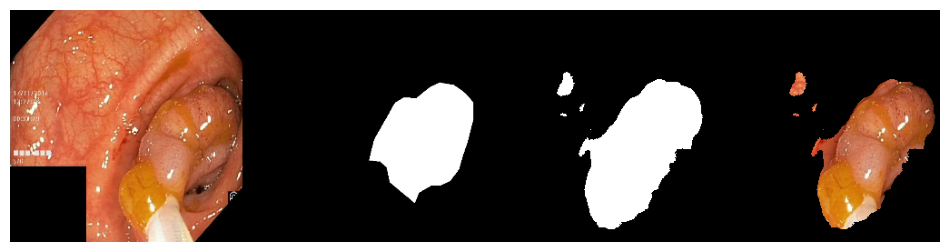

 Epoch: 5 of 50, Iter.: 100 of 100, Train Loss: 0.653550, IoU: 0.539823, Dice: 0.657824
 Epoch: 5 of 50, Iter.: 100 of 100, Valid Loss: 0.677284, IoU: 0.521874, Dice: 0.629246


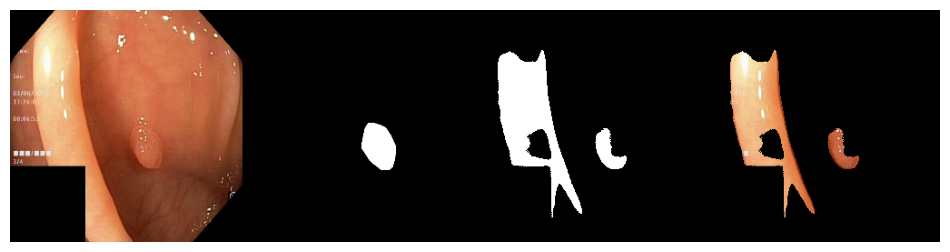

 Epoch: 6 of 50, Iter.: 100 of 100, Train Loss: 0.584662, IoU: 0.582160, Dice: 0.695653
 Epoch: 6 of 50, Iter.: 100 of 100, Valid Loss: 0.651222, IoU: 0.555307, Dice: 0.669976


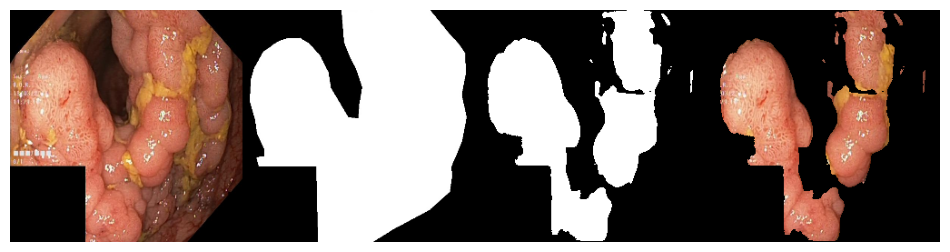

 Epoch: 7 of 50, Iter.: 100 of 100, Train Loss: 0.525237, IoU: 0.619351, Dice: 0.726334
 Epoch: 7 of 50, Iter.: 100 of 100, Valid Loss: 0.676176, IoU: 0.506534, Dice: 0.600380


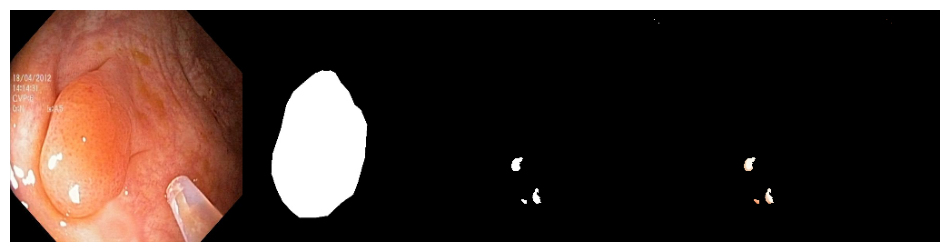

 Epoch: 8 of 50, Iter.: 100 of 100, Train Loss: 0.489626, IoU: 0.640309, Dice: 0.743739
 Epoch: 8 of 50, Iter.: 100 of 100, Valid Loss: 0.554349, IoU: 0.605254, Dice: 0.711282


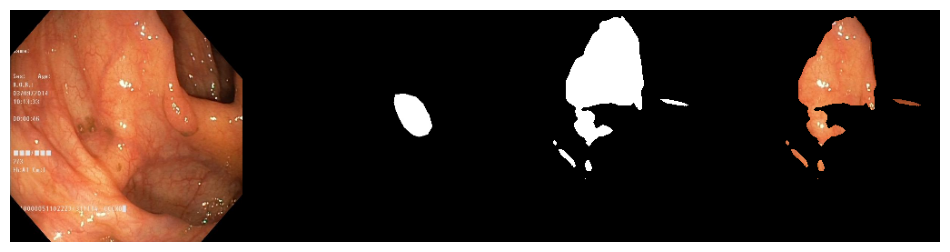

 Epoch: 9 of 50, Iter.: 100 of 100, Train Loss: 0.439284, IoU: 0.679149, Dice: 0.778796
 Epoch: 9 of 50, Iter.: 100 of 100, Valid Loss: 0.583780, IoU: 0.595346, Dice: 0.692413


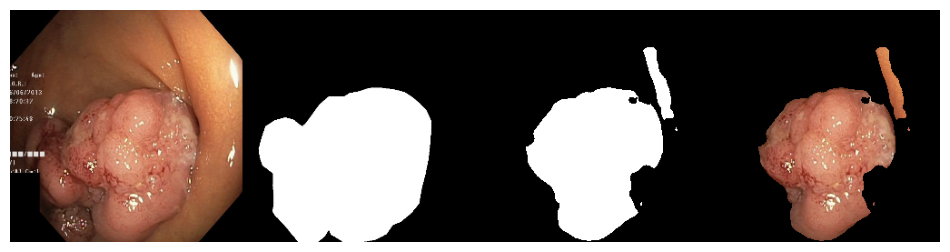

 Epoch: 10 of 50, Iter.: 100 of 100, Train Loss: 0.410362, IoU: 0.693424, Dice: 0.789334
 Epoch: 10 of 50, Iter.: 100 of 100, Valid Loss: 0.530908, IoU: 0.630317, Dice: 0.729713


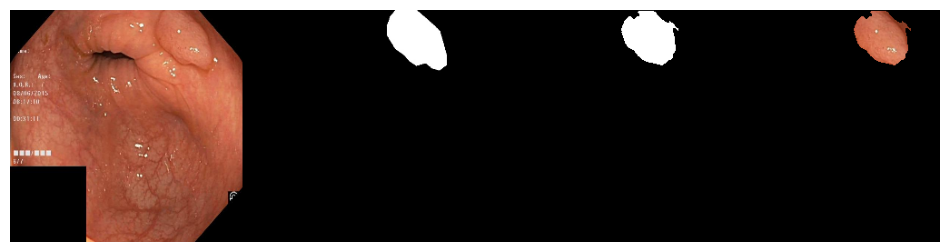

 Epoch: 11 of 50, Iter.: 100 of 100, Train Loss: 0.376441, IoU: 0.714317, Dice: 0.803534
 Epoch: 11 of 50, Iter.: 100 of 100, Valid Loss: 0.542434, IoU: 0.634083, Dice: 0.730969


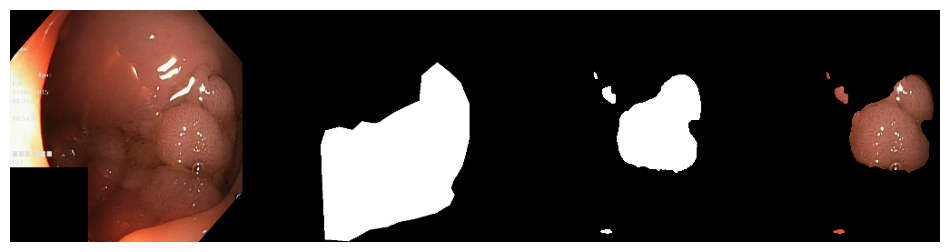

 Epoch: 12 of 50, Iter.: 100 of 100, Train Loss: 0.363065, IoU: 0.721303, Dice: 0.811133
 Epoch: 12 of 50, Iter.: 100 of 100, Valid Loss: 0.506635, IoU: 0.657049, Dice: 0.756002


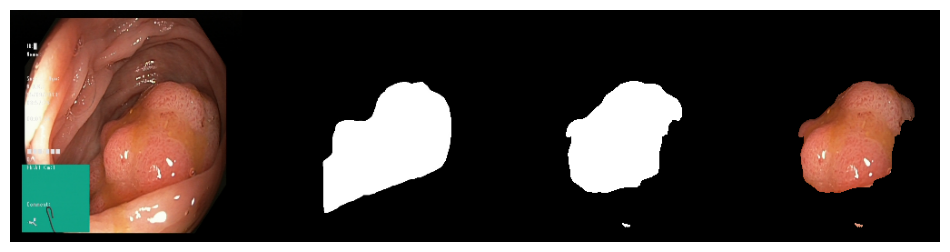

 Epoch: 13 of 50, Iter.: 100 of 100, Train Loss: 0.319973, IoU: 0.747151, Dice: 0.830615
 Epoch: 13 of 50, Iter.: 100 of 100, Valid Loss: 0.490067, IoU: 0.669776, Dice: 0.763796


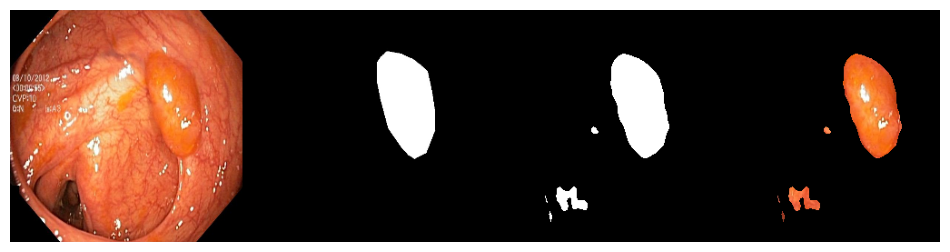

 Epoch: 14 of 50, Iter.: 100 of 100, Train Loss: 0.314012, IoU: 0.755635, Dice: 0.836965
 Epoch: 14 of 50, Iter.: 100 of 100, Valid Loss: 0.505182, IoU: 0.644297, Dice: 0.747832


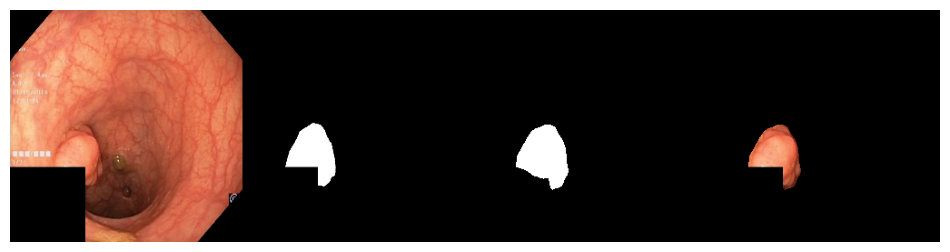

 Epoch: 15 of 50, Iter.: 100 of 100, Train Loss: 0.293217, IoU: 0.767971, Dice: 0.847456
 Epoch: 15 of 50, Iter.: 100 of 100, Valid Loss: 0.492759, IoU: 0.666184, Dice: 0.766018


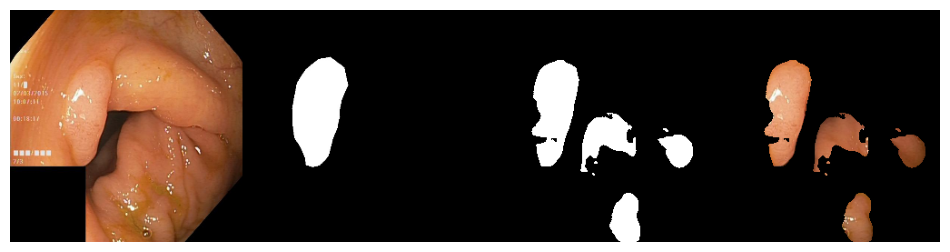

 Epoch: 16 of 50, Iter.: 100 of 100, Train Loss: 0.268151, IoU: 0.785571, Dice: 0.859579
 Epoch: 16 of 50, Iter.: 100 of 100, Valid Loss: 0.455535, IoU: 0.682818, Dice: 0.771157


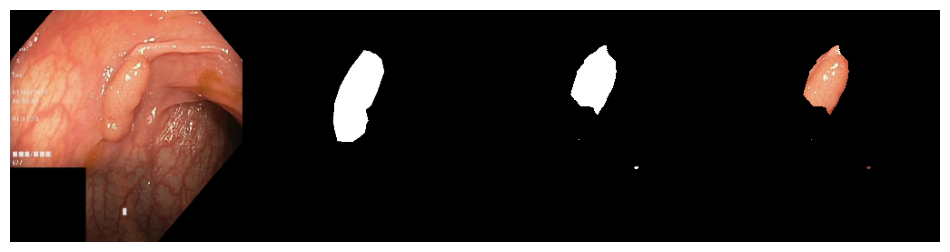

 Epoch: 17 of 50, Iter.: 100 of 100, Train Loss: 0.245534, IoU: 0.792877, Dice: 0.866014
 Epoch: 17 of 50, Iter.: 100 of 100, Valid Loss: 0.471951, IoU: 0.680063, Dice: 0.774736


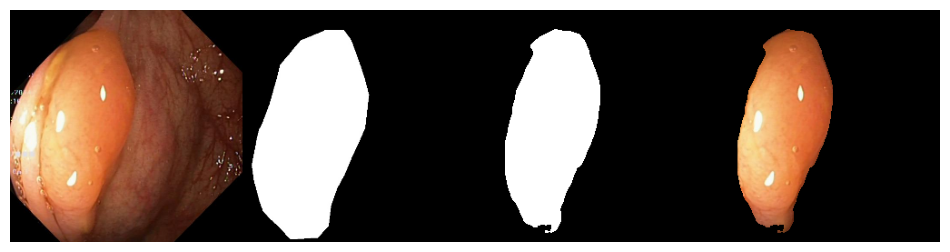

 Epoch: 18 of 50, Iter.: 100 of 100, Train Loss: 0.210562, IoU: 0.820156, Dice: 0.885611
 Epoch: 18 of 50, Iter.: 100 of 100, Valid Loss: 0.498701, IoU: 0.657012, Dice: 0.744068


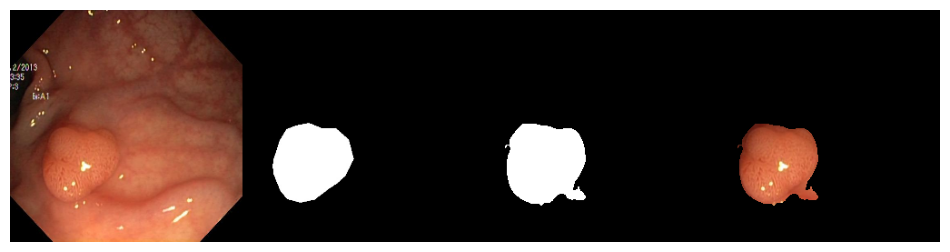

 Epoch: 19 of 50, Iter.: 100 of 100, Train Loss: 0.189283, IoU: 0.836520, Dice: 0.898131
 Epoch: 19 of 50, Iter.: 100 of 100, Valid Loss: 0.457267, IoU: 0.692448, Dice: 0.778705


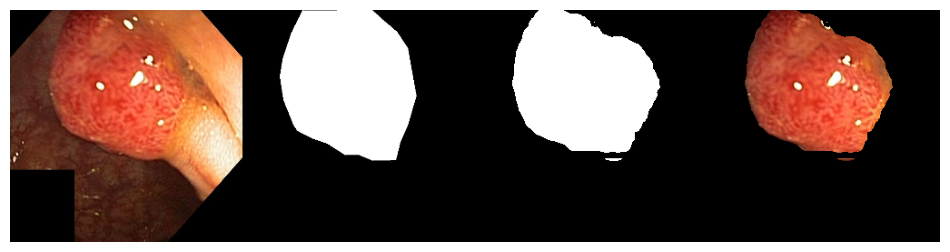

 Epoch: 20 of 50, Iter.: 100 of 100, Train Loss: 0.219109, IoU: 0.813027, Dice: 0.881324
 Epoch: 20 of 50, Iter.: 100 of 100, Valid Loss: 0.513597, IoU: 0.666750, Dice: 0.767402


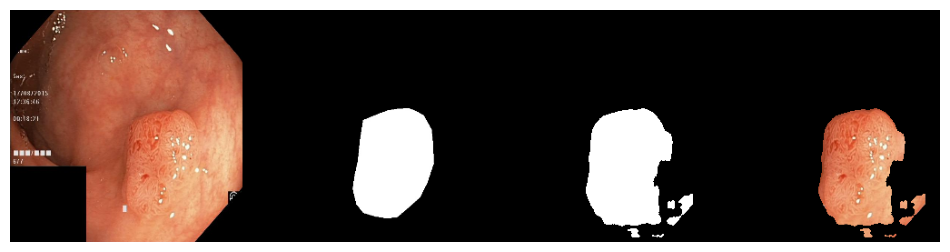

 Epoch: 21 of 50, Iter.: 100 of 100, Train Loss: 0.191570, IoU: 0.828882, Dice: 0.892456
 Epoch: 21 of 50, Iter.: 100 of 100, Valid Loss: 0.479456, IoU: 0.679035, Dice: 0.767213


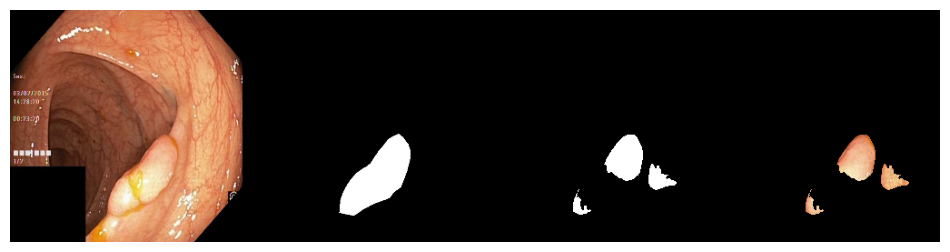

 Epoch: 22 of 50, Iter.: 100 of 100, Train Loss: 0.156163, IoU: 0.854271, Dice: 0.911182
 Epoch: 22 of 50, Iter.: 100 of 100, Valid Loss: 0.484438, IoU: 0.670846, Dice: 0.755188


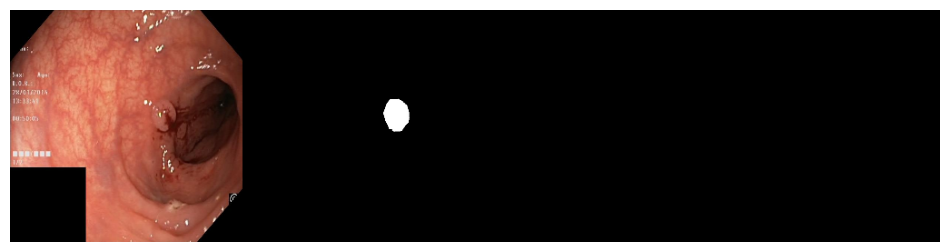

 Epoch: 23 of 50, Iter.: 100 of 100, Train Loss: 0.150873, IoU: 0.855310, Dice: 0.910017
 Epoch: 23 of 50, Iter.: 100 of 100, Valid Loss: 0.503384, IoU: 0.661835, Dice: 0.750024


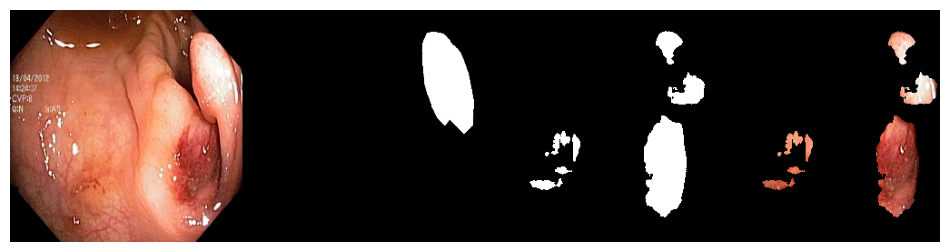

 Epoch: 24 of 50, Iter.: 100 of 100, Train Loss: 0.147020, IoU: 0.862457, Dice: 0.916046
 Epoch: 24 of 50, Iter.: 100 of 100, Valid Loss: 0.434680, IoU: 0.705374, Dice: 0.799581


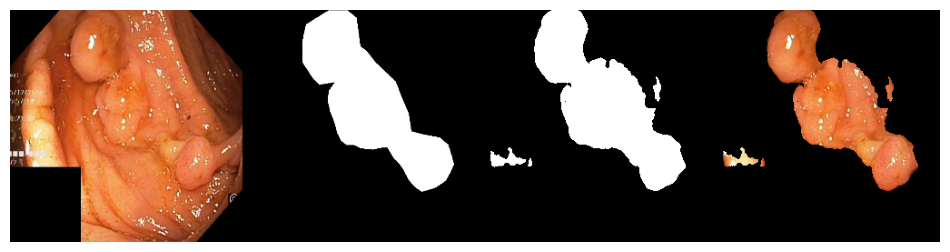

 Epoch: 25 of 50, Iter.: 100 of 100, Train Loss: 0.155018, IoU: 0.854916, Dice: 0.909168
 Epoch: 25 of 50, Iter.: 100 of 100, Valid Loss: 0.525595, IoU: 0.672203, Dice: 0.760749


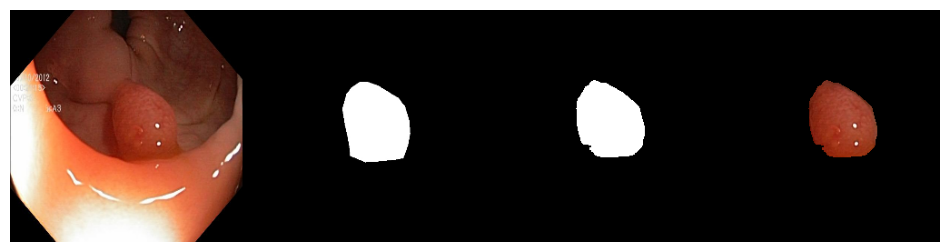

 Epoch: 26 of 50, Iter.: 100 of 100, Train Loss: 0.158857, IoU: 0.851972, Dice: 0.909346
 Epoch: 26 of 50, Iter.: 100 of 100, Valid Loss: 0.508697, IoU: 0.658286, Dice: 0.749597


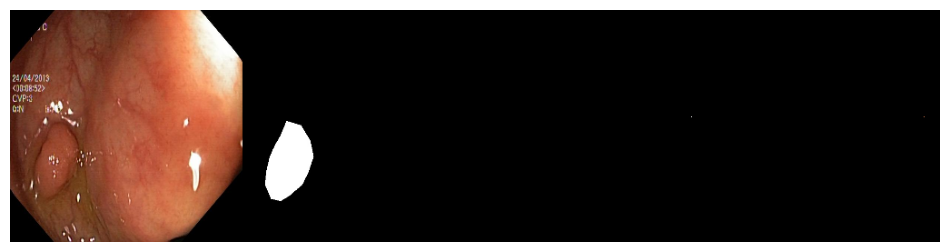

 Epoch: 27 of 50, Iter.: 100 of 100, Train Loss: 0.115251, IoU: 0.884079, Dice: 0.930757
 Epoch: 27 of 50, Iter.: 100 of 100, Valid Loss: 0.487968, IoU: 0.700460, Dice: 0.783120


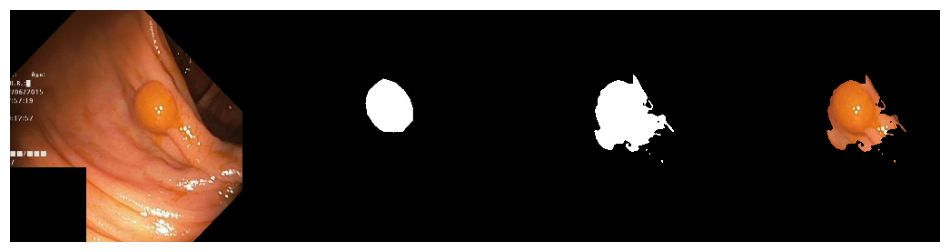

 Epoch: 28 of 50, Iter.: 100 of 100, Train Loss: 0.116277, IoU: 0.883716, Dice: 0.929458
 Epoch: 28 of 50, Iter.: 100 of 100, Valid Loss: 0.474989, IoU: 0.699142, Dice: 0.791715


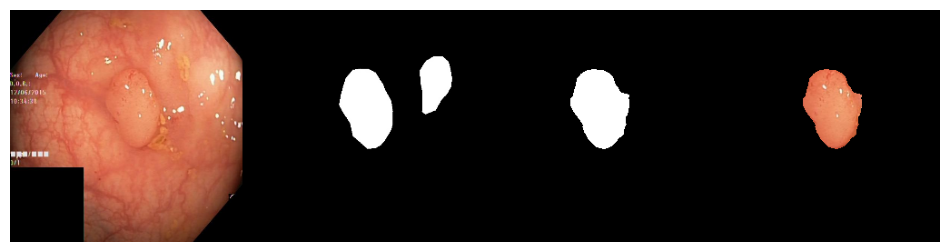

 Epoch: 29 of 50, Iter.: 100 of 100, Train Loss: 0.104490, IoU: 0.891994, Dice: 0.937200
 Epoch: 29 of 50, Iter.: 100 of 100, Valid Loss: 0.473263, IoU: 0.706964, Dice: 0.794746


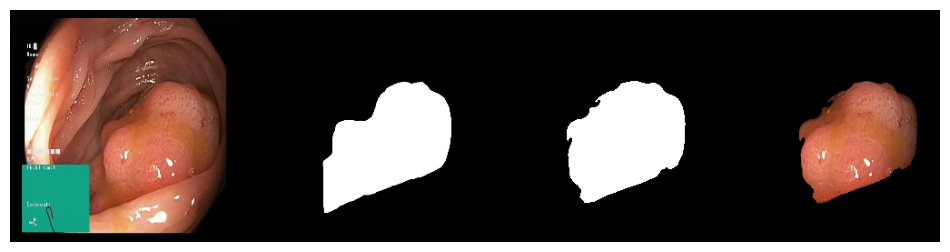

 Epoch: 30 of 50, Iter.: 100 of 100, Train Loss: 0.094230, IoU: 0.900520, Dice: 0.942294
 Epoch: 30 of 50, Iter.: 100 of 100, Valid Loss: 0.484580, IoU: 0.709657, Dice: 0.795821


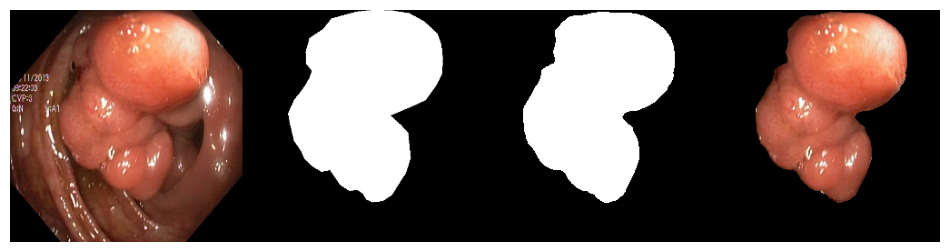

 Epoch: 31 of 50, Iter.: 100 of 100, Train Loss: 0.080367, IoU: 0.911195, Dice: 0.948776
 Epoch: 31 of 50, Iter.: 100 of 100, Valid Loss: 0.477769, IoU: 0.694550, Dice: 0.783943


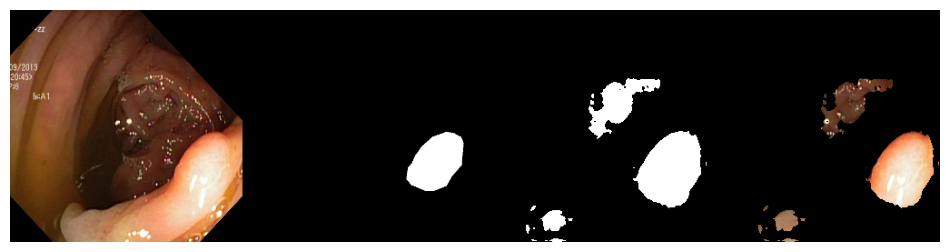

 Epoch: 32 of 50, Iter.: 100 of 100, Train Loss: 0.082972, IoU: 0.909657, Dice: 0.948838
 Epoch: 32 of 50, Iter.: 100 of 100, Valid Loss: 0.461762, IoU: 0.704879, Dice: 0.793589


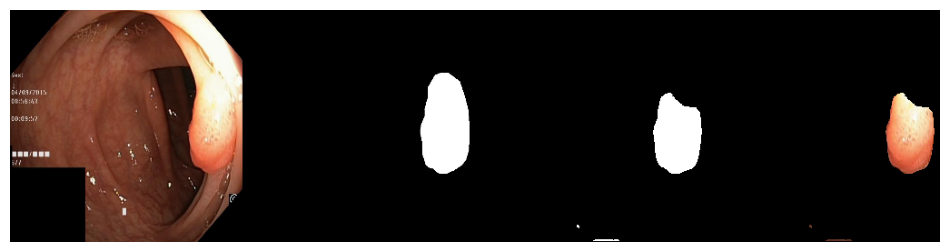

 Epoch: 33 of 50, Iter.: 100 of 100, Train Loss: 0.072738, IoU: 0.918294, Dice: 0.953340
 Epoch: 33 of 50, Iter.: 100 of 100, Valid Loss: 0.456471, IoU: 0.724699, Dice: 0.806216


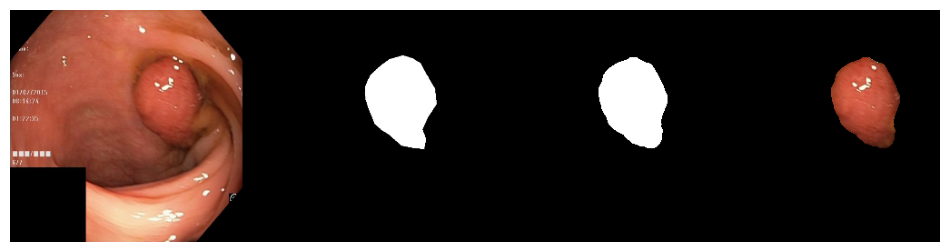

 Epoch: 34 of 50, Iter.: 100 of 100, Train Loss: 0.066644, IoU: 0.924633, Dice: 0.957690
 Epoch: 34 of 50, Iter.: 100 of 100, Valid Loss: 0.457399, IoU: 0.724041, Dice: 0.806327


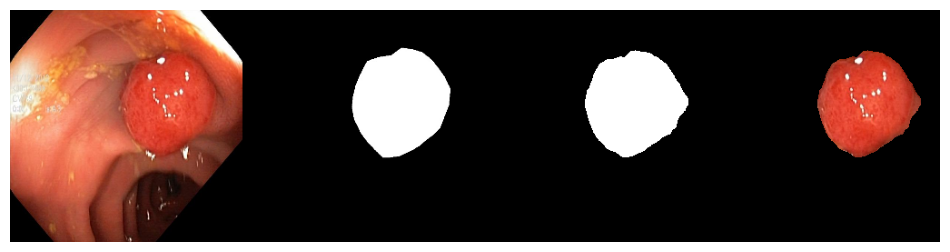

 Epoch: 35 of 50, Iter.: 100 of 100, Train Loss: 0.062208, IoU: 0.928834, Dice: 0.959817
 Epoch: 35 of 50, Iter.: 100 of 100, Valid Loss: 0.497020, IoU: 0.710587, Dice: 0.795029


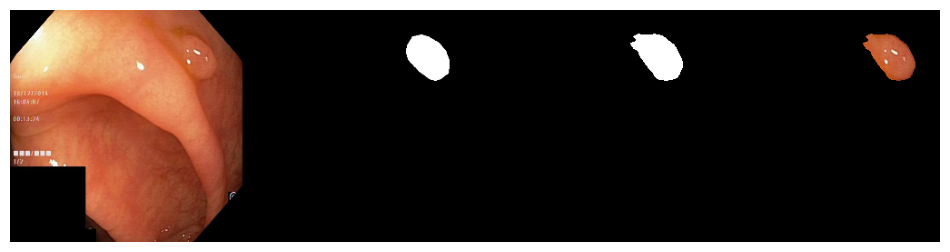

 Epoch: 36 of 50, Iter.: 100 of 100, Train Loss: 0.062945, IoU: 0.925596, Dice: 0.957150
 Epoch: 36 of 50, Iter.: 100 of 100, Valid Loss: 0.476653, IoU: 0.716654, Dice: 0.806766


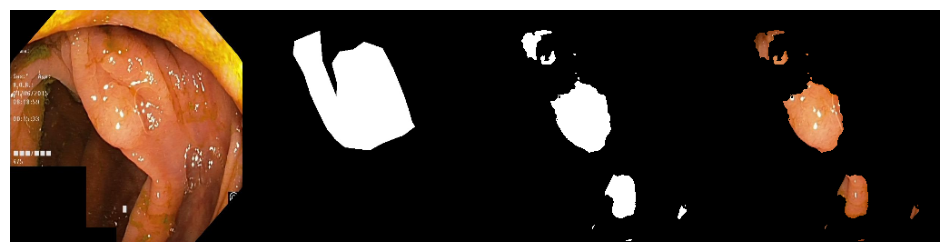

 Epoch: 37 of 50, Iter.: 100 of 100, Train Loss: 0.059145, IoU: 0.930897, Dice: 0.961742
 Epoch: 37 of 50, Iter.: 100 of 100, Valid Loss: 0.479688, IoU: 0.718561, Dice: 0.804648


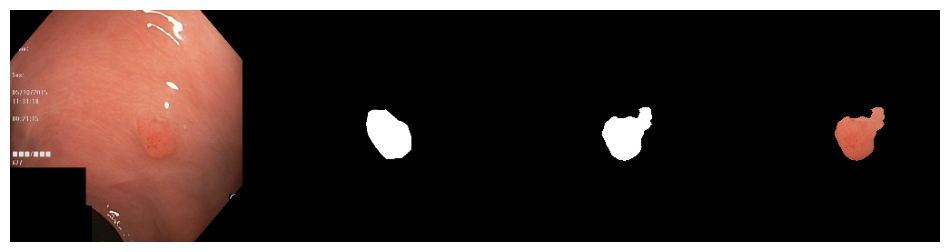

 Epoch: 38 of 50, Iter.: 100 of 100, Train Loss: 0.053725, IoU: 0.934659, Dice: 0.963238
 Epoch: 38 of 50, Iter.: 100 of 100, Valid Loss: 0.489785, IoU: 0.708806, Dice: 0.800728


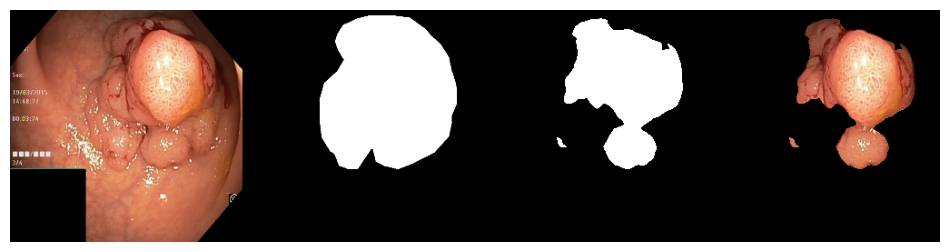

 Epoch: 39 of 50, Iter.: 100 of 100, Train Loss: 0.062342, IoU: 0.926202, Dice: 0.958799
 Epoch: 39 of 50, Iter.: 100 of 100, Valid Loss: 0.455975, IoU: 0.726744, Dice: 0.812434


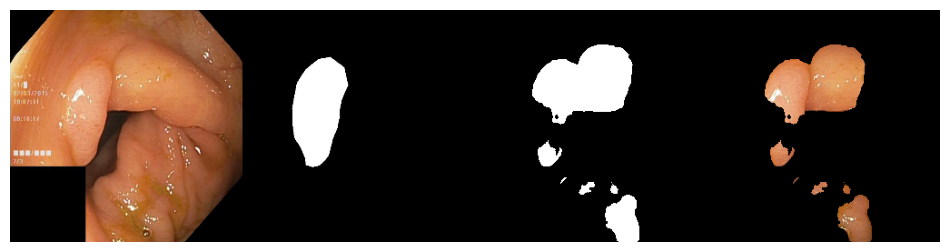

 Epoch: 40 of 50, Iter.: 100 of 100, Train Loss: 0.066035, IoU: 0.922419, Dice: 0.956431
 Epoch: 40 of 50, Iter.: 100 of 100, Valid Loss: 0.549140, IoU: 0.690795, Dice: 0.775772


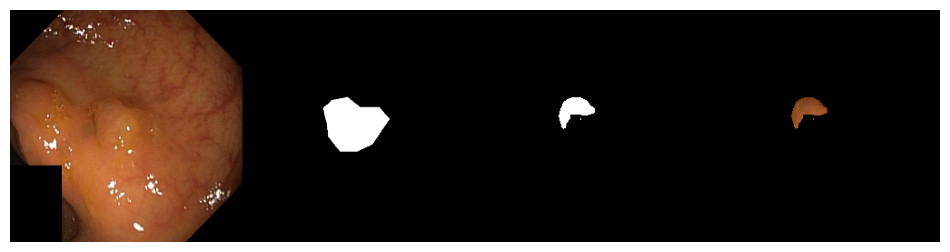

 Epoch: 41 of 50, Iter.: 100 of 100, Train Loss: 0.055710, IoU: 0.932421, Dice: 0.962559
 Epoch: 41 of 50, Iter.: 100 of 100, Valid Loss: 0.472603, IoU: 0.721057, Dice: 0.807392


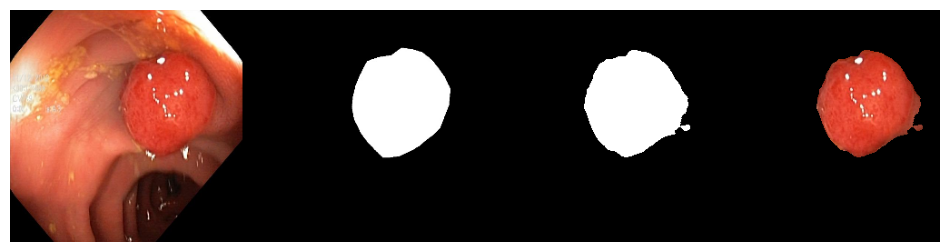

 Epoch: 42 of 50, Iter.: 100 of 100, Train Loss: 0.056890, IoU: 0.931700, Dice: 0.962173
 Epoch: 42 of 50, Iter.: 100 of 100, Valid Loss: 0.553124, IoU: 0.670993, Dice: 0.775341


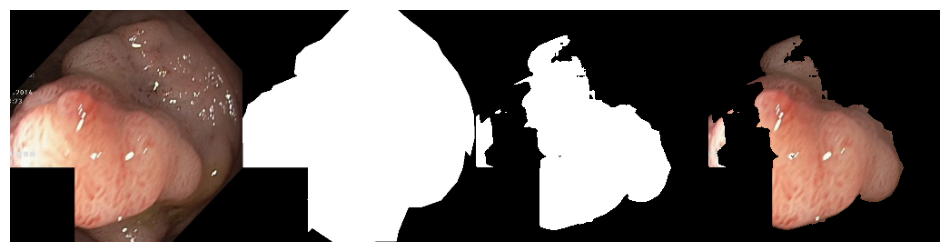

 Epoch: 43 of 50, Iter.: 100 of 100, Train Loss: 0.137818, IoU: 0.863751, Dice: 0.916907
 Epoch: 43 of 50, Iter.: 100 of 100, Valid Loss: 0.664126, IoU: 0.623309, Dice: 0.720140


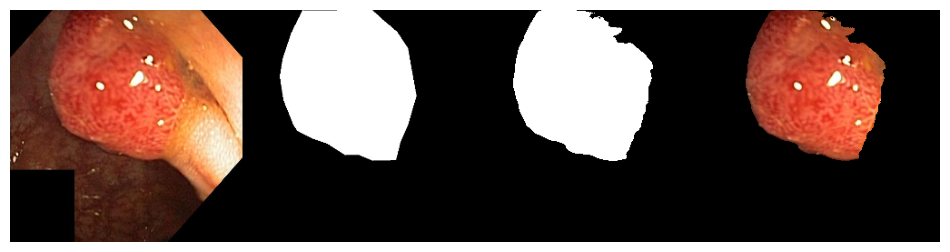

 Epoch: 44 of 50, Iter.: 100 of 100, Train Loss: 0.168828, IoU: 0.842508, Dice: 0.902104
 Epoch: 44 of 50, Iter.: 100 of 100, Valid Loss: 0.517868, IoU: 0.666262, Dice: 0.757825


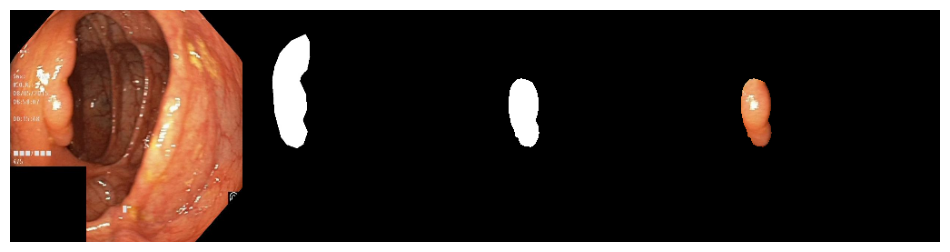

 Epoch: 45 of 50, Iter.: 100 of 100, Train Loss: 0.082393, IoU: 0.906772, Dice: 0.946522
 Epoch: 45 of 50, Iter.: 100 of 100, Valid Loss: 0.587908, IoU: 0.650500, Dice: 0.735027


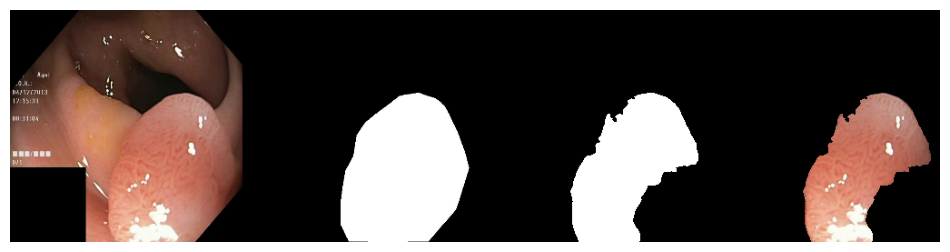

 Epoch: 46 of 50, Iter.: 100 of 100, Train Loss: 0.086669, IoU: 0.904475, Dice: 0.945424
 Epoch: 46 of 50, Iter.: 100 of 100, Valid Loss: 0.512250, IoU: 0.687639, Dice: 0.782001


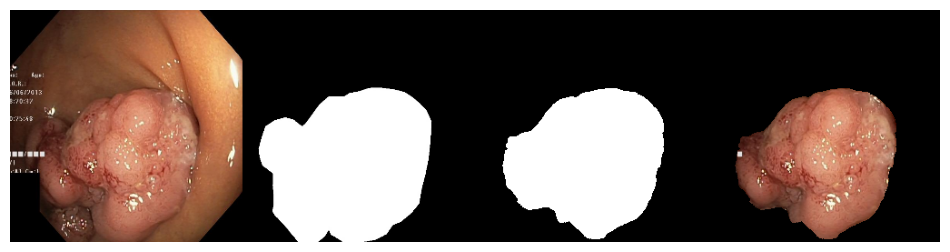

 Epoch: 47 of 50, Iter.: 100 of 100, Train Loss: 0.066921, IoU: 0.920202, Dice: 0.955196
 Epoch: 47 of 50, Iter.: 100 of 100, Valid Loss: 0.548520, IoU: 0.687874, Dice: 0.773609


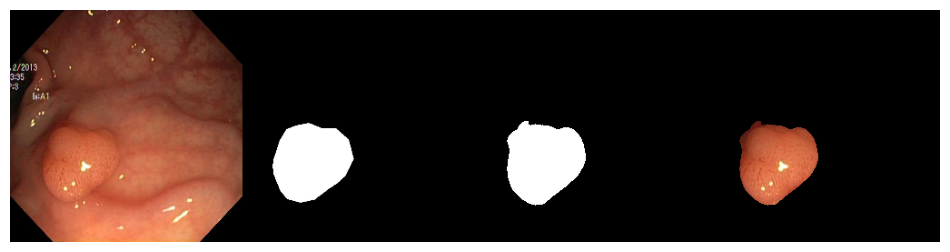

 Epoch: 48 of 50, Iter.: 100 of 100, Train Loss: 0.053410, IoU: 0.933991, Dice: 0.962833
 Epoch: 48 of 50, Iter.: 100 of 100, Valid Loss: 0.528675, IoU: 0.706840, Dice: 0.790513


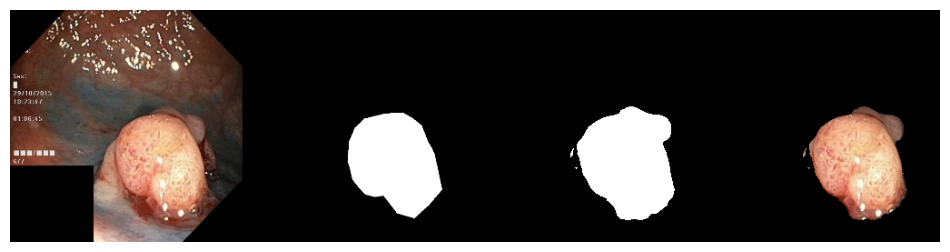

 Epoch: 49 of 50, Iter.: 100 of 100, Train Loss: 0.048699, IoU: 0.939157, Dice: 0.966460
 Epoch: 49 of 50, Iter.: 100 of 100, Valid Loss: 0.523907, IoU: 0.705927, Dice: 0.787476


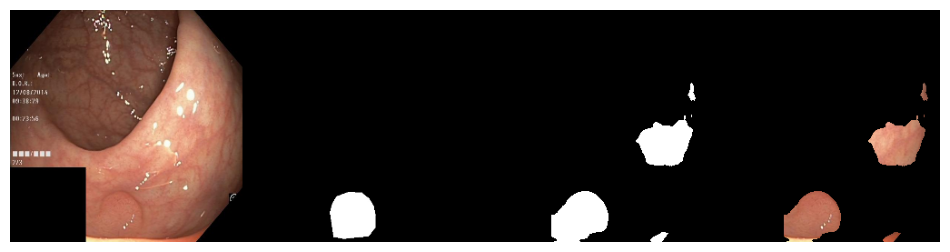

CPU times: user 9min 36s, sys: 4min 31s, total: 14min 7s
Wall time: 10min 20s


In [17]:

%%time
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test
from ploting import plot_model_prediction

data_name = 'ISIC'

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch = -1
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

for epoch in range(epochs):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 0:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    if epoch+1 % 10 == 0:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
        for i, (metric, value) in enumerate(metrics.items()):
            axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=3)
            axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=3)
            axs[i].set_xlabel('Epoch')
            axs[i].set_ylabel('Loss')
            axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
            axs[i].legend(loc='best')
        plt.show()
    
    lst_epoch_metric.append([round(epoch_train_loss,2), round(epoch_val_loss,2), round(epoch_train_iou,2), 
                             round(epoch_val_iou,2), round(epoch_train_dice,2), round(epoch_val_dice,2)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_iou = epoch if best_iou == epoch_val_iou else best_epoch_iou
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

# load once more and write all the losses down (othw can miss the last 10)
state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'metric_{model_name}_{data_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_IOU:0.7267, Best_DiceScore:0.8124


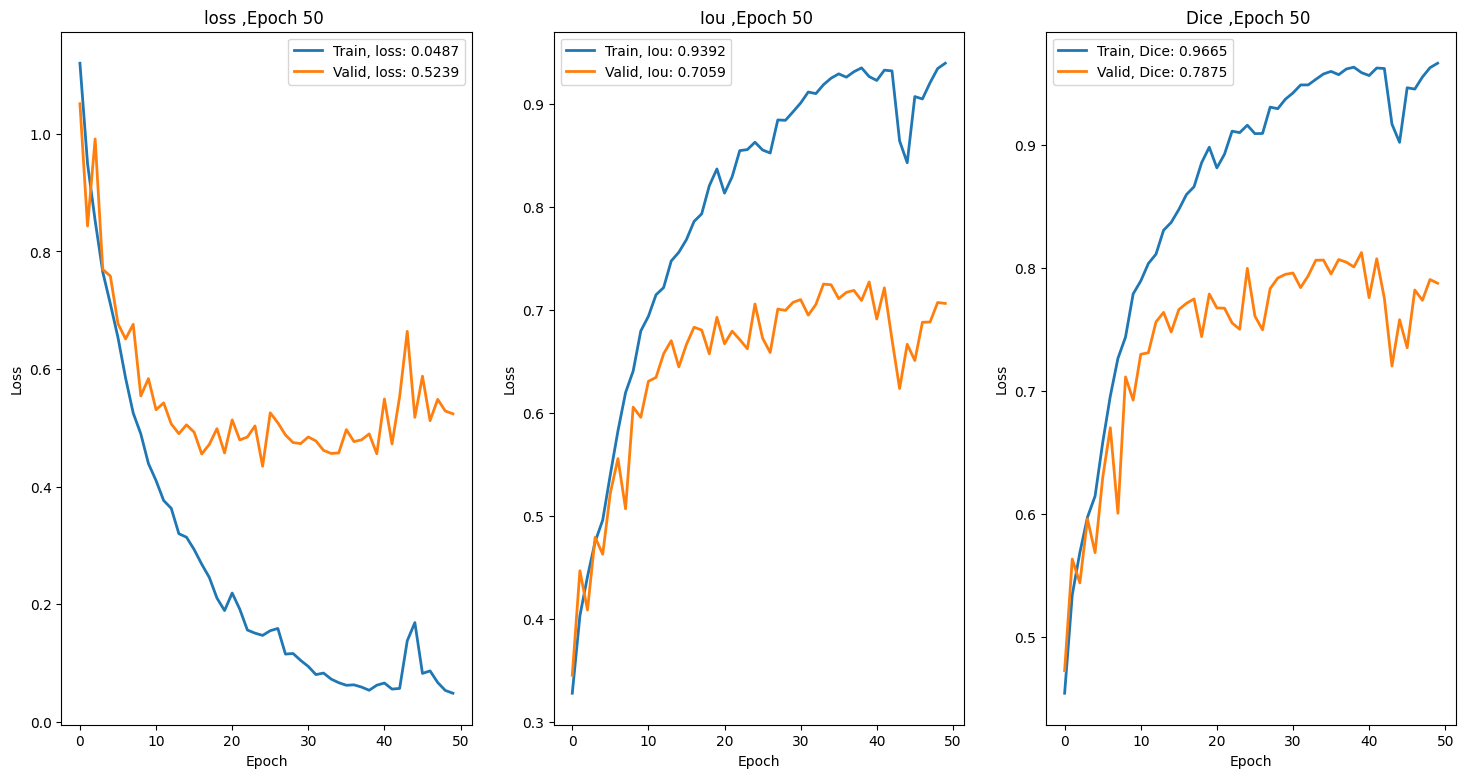

In [18]:
print(f'Validationset 기준 \nBest_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

# metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
#            'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
#            'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch+1} ')
    axs[i].legend(loc='best')
plt.show()